## Executions to use

USE_ENERGY_PROTEINS = True and MULTIPLE_CATEGORIES = False: cancer_research/results/xgb_binary_energy_20210324_1159
USE_ENERGY_PROTEINS = True and MULTIPLE_CATEGORIES = True: cancer_research/results/xgb_multi_energy_20210326_0845
USE_ENERGY_PROTEINS = False and MULTIPLE_CATEGORIES = True: cancer_research/results/xgb_multi_no_energy_20210327_0037
USE_ENERGY_PROTEINS = False and MULTIPLE_CATEGORIES = False: cancer_research/results/xgb_binary_no_energy_20210327_1624

In [1]:
%matplotlib inline

import os
import sys
import shap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from copy import deepcopy
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Any, Union, Optional

from xgboost import XGBClassifier

from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score


shap.initjs()

In [2]:
#from cancer_package import constants, reporters, preprocessing, transformers
import cancer_package.constants as constants
import cancer_package.reporters as reporters
import cancer_package.preprocessing as preprocessing
import cancer_package.transformers as transformers
import cancer_package.pipeline_tuner as pipeline_tuner
import cancer_package.utilities as utilities

In [5]:
USE_ENERGY_PROTEINS = False
USE_MOCK = False
MULTIPLE_CATEGORIES = False
NON_NAN_THRESH = .7
REPLACE_BY_NAN = False
N_FOLDS = 10

In [6]:
if USE_ENERGY_PROTEINS and MULTIPLE_CATEGORIES:
    results_base = 'xgb_multi_energy'
elif not USE_ENERGY_PROTEINS and MULTIPLE_CATEGORIES:
    results_base = 'xgb_multi_no_energy'
elif USE_ENERGY_PROTEINS and not MULTIPLE_CATEGORIES:
    results_base = 'xgb_binary_energy'
elif not USE_ENERGY_PROTEINS and not MULTIPLE_CATEGORIES:
    results_base = 'xgb_binary_no_energy'
else:
    raise ValueError("wong combination of parameters")

# 1. Preprocessing

## 1.1. Basic preprocessing:
Removing empty columns, shuffling data, computing biological features, removing columns with excess NaNs

original dataset shape: (231, 117)
rm 22 proteins with no data
rm 28 energy proteins


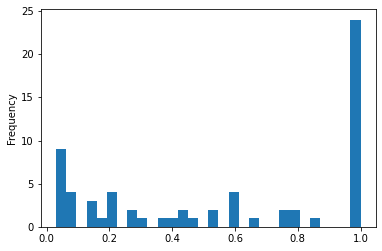

preprocessed dataset shape: (231, 176)
GC           47
CTL          33
LC           33
CCA          25
LD (PM)      23
CRC          22
LD (COPD)    17
BC           17
EC           14
Name: category, dtype: int64


In [8]:
if USE_MOCK:
    data = pd.read_csv( os.path.join(constants.MOCK_DATA_DIRECTORY, 'cancer_and_ld_patients.csv'))
    formulas_df = pd.read_csv( os.path.join(constants.MOCK_DATA_DIRECTORY, 'formulas.csv'))
    protein_group = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'protein_group.csv'))
else:
    data = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'cancer_and_ld_patients.csv'))
    formulas_df = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'formulas.csv'))
    protein_group = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'protein_group.csv'))

# checking we have data
print(f"original dataset shape: {data.shape}")

data_prep = preprocessing.BasicPreprocessing(data, constants.NA_VALUE, USE_ENERGY_PROTEINS)
data_prep.organise_proteins(protein_group)
data_prep.non_nan_share_hist(bins=30)
data_prep.bio_features(formulas_df)
data_prep.rm_execess_nans(NON_NAN_THRESH, by_group=False)

if REPLACE_BY_NAN:
    data_prep.replace_nans()
    print("replaced NaNs")

data = data_prep.data
PROTEINS = data_prep.proteins
FORMULAS_DF = data_prep.formulas_df
FEATURE_NAMES = data_prep.feature_names()

print(f"preprocessed dataset shape: {data.shape}")
print(data.category.value_counts())

## 1.2. Aggregate categories

In [9]:
X_train, y_train = data[FEATURE_NAMES], data["category"]

if MULTIPLE_CATEGORIES:
    category_mapping = {('LD (COPD)', 'LD (PM)'): "LD"}#, ('BC', 'CRC', 'EC'): "OtherC"}
else:
    category_mapping = {
        ('CTL', 'LD (COPD)', 'LD (PM)'): "NonCancer",
        ('GC', 'LC', 'CCA', 'CRC', 'BC', 'EC'): "Cancer"
    }
category_encoder = transformers.MapCategories( category_mapping)
y_train = category_encoder.fit_transform( y_train)

if REPLACE_BY_NAN:
    X_train.fillna(constants.NA_VALUE, inplace=True)

print("verification the transformation went fine")
category_encoder.inverse_transform( y_train).value_counts() / len(y_train)

verification the transformation went fine


Cancer       0.683983
NonCancer    0.316017
Name: category, dtype: float64

# XGB PIPELINE

In [10]:
def create_xgb_pipe():
    """
    Creates a XGBoost model depending on the classification problem type.
    The categories were aggregates such that there are only 2 then it will 
    treat it as a binary problem, if there are more then 2 then it will a
    multiple classification problem.
    
    :raise ValueError: if there is < 2 classes 
    :return: an XGBoost model within a pipeline
    """
    if len(category_encoder.classes_) == 2:
        xgb_model = XGBClassifier(
          objective="binary:logistic",
          n_jobs=-1,  
          #eval_metric="auc", #['mlogloss', 'merror'],
          random_state=666
        )
    elif len(category_encoder.classes_) > 2:
        xgb_model = XGBClassifier(
          objective='multi:sofprob', # 'multi:softmax',
          n_jobs=-1,  
          num_class=len(category_encoder.classes_),
          #eval_metric="mlogloss",
          random_state=666
        )
    else:
        raise ValueError("it isn't possible to have less than 2 classes")

    xgb_pipe = Pipeline(steps=[("model", xgb_model)])

    return xgb_pipe

In [22]:
import importlib
importlib.reload(pipeline_tuner)
#importlib.reload(utilities)

<module 'cancer_package.pipeline_tuner' from '/home/jupyter/cancer_research/cancer_package/pipeline_tuner.py'>

model save in: xgb_binary_no_energy_20210327_1624

step 0 starts
len(selected_cols) 174
X_train.shape (231, 174)
best_score_iter -0.2958846972765995
score with 174 features: -29.59%
best score so far, model:
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.8598493484482015, 'colsample_bynode': 0.6132215091574345, 'colsample_bytree': 0.41608734450929086, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.28161769996720365, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 29, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 666, 'reg_alpha': 0, 'reg_lambda': 5.040994016933976, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
step 0: 0:04:30

step 1 starts
-- rm 73 features


array(['HSP90AB1', 'HSP90B1', 'HSPA2', 'HSPA8', 'HSPA9', 'DNAJA1',
       'HSPD1', 'HSPB1', 'CCT1', 'gg1', 'gg2', 'gg5', 'gg10', 'gg11',
       'gg25', 'gg41', 'gg42', 'gg43', 'gg44', 'oo1', 'oo2', 'oo5', 'oo6',
       'oo7', 'oo14', 'oo15', 'oo21', 'oo25', 'oo26', 'oo27', 'oo28',
       'hh2', 'hh6', 'hh7', 'hh8', 'hh10', 'hh12', 'hh15', 'hh17', 'hh18',
       'hh21', 'hh23', 'hh24', 'hh25', 'm3', 'm4', 'm7', 'm16', 'm20',
       'm23', 'm30', 'm31', 'm32', 'm34', 'm35', 'm39', 'm40', 'm41',
       'm44', 'm48', 'm49', 'm50', 'm51', 'm53', 'm54', 'm56', 'm57',
       'm58', 'm59', 'm65', 'm66', 'm67', 'm68'], dtype=object)

len(selected_cols) 101
X_train.shape (231, 101)
best_score_iter -0.28549361461967543
score with 101 features: -28.55%
best score so far, model:
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.9684499605391264, 'colsample_bynode': 0.3074615603191512, 'colsample_bytree': 0.936507101042539, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.2991598302746342, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 23, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 666, 'reg_alpha': 0, 'reg_lambda': 0.6151427344654614, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
step 1: 0:04:24

step 2 starts
-- rm 44 features


array(['HSPA5', 'HSPA4', 'HSPB5', 'gg3', 'gg6', 'gg8', 'gg45', 'gg48',
       'oo4', 'oo8', 'oo9', 'oo10', 'oo13', 'oo19', 'oo20', 'oo24',
       'oo46', 'hh1', 'hh3', 'hh13', 'hh16', 'hh22', 'hh29', 'm5', 'm8',
       'm9', 'm13', 'm15', 'm18', 'm19', 'm25', 'm26', 'm27', 'm29',
       'm36', 'm37', 'm38', 'm45', 'm46', 'm47', 'm55', 'm60', 'm62',
       'm63'], dtype=object)

len(selected_cols) 57
X_train.shape (231, 57)
best_score_iter -0.2562715083227385
score with 57 features: -25.63%
best score so far, model:
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.8953808837040635, 'colsample_bynode': 0.9880629918400246, 'colsample_bytree': 0.41103401095709896, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.29188182583914923, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 25, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 666, 'reg_alpha': 0, 'reg_lambda': 0.5582250077297413, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
step 2: 0:04:17

step 3 starts
-- rm 6 features


array(['TRAP1', 'CCT6A', 'gg9', 'hh11', 'm1', 'm14'], dtype=object)

len(selected_cols) 51
X_train.shape (231, 51)
best_score_iter -0.28196779893950785
score with 51 features: -28.20%
step 3: 0:04:25

step 4 starts
-- rm 21 features


array(['HSP90AA1', 'HSPA6', 'CCT2', 'CCT4', 'CCT8', 'gg4', 'gg46', 'oo16',
       'oo17', 'oo18', 'oo22', 'oo23', 'hh5', 'hh14', 'hh20', 'hh27',
       'm12', 'm22', 'm33', 'm43', 'm61'], dtype=object)

len(selected_cols) 30
X_train.shape (231, 30)
best_score_iter -0.2535888039241874
score with 30 features: -25.36%
best score so far, model:
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.9616439492337072, 'colsample_bynode': 0.3, 'colsample_bytree': 1.0, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 30, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 666, 'reg_alpha': 0, 'reg_lambda': 4.3271656751383186e-09, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
step 4: 0:04:14

step 5 starts
-- rm 1 features


array(['gg40'], dtype=object)

len(selected_cols) 29
X_train.shape (231, 29)
best_score_iter -0.2528748607956821
score with 29 features: -25.29%
best score so far, model:
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.9962133504999264, 'colsample_bynode': 0.9826091851993903, 'colsample_bytree': 0.5282500943121311, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.29021999747645855, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 23, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 666, 'reg_alpha': 0, 'reg_lambda': 0.10693130307365406, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
step 5: 0:04:19

step 6 starts
-- rm 1 features


array(['ST13'], dtype=object)

len(selected_cols) 28
X_train.shape (231, 28)
best_score_iter -0.24471707577847512
score with 28 features: -24.47%
best score so far, model:
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 0.3, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 28, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 666, 'reg_alpha': 0, 'reg_lambda': 0.0, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
step 6: 0:04:23

step 7 starts
-- rm 1 features


array(['m11'], dtype=object)

len(selected_cols) 27
X_train.shape (231, 27)
best_score_iter -0.24398614682798758
score with 27 features: -24.40%
best score so far, model:
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7861070744351207, 'colsample_bynode': 0.8774093251503836, 'colsample_bytree': 0.6259679327570861, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.28810488190533123, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 30, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 666, 'reg_alpha': 0, 'reg_lambda': 1.696362575837671, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
step 7: 0:04:33

step 8 starts
-- rm 1 features


array(['m6'], dtype=object)

len(selected_cols) 26
X_train.shape (231, 26)
best_score_iter -0.22614863791085016
score with 26 features: -22.61%
best score so far, model:
 {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.5454099127837428, 'colsample_bynode': 0.9850184992025173, 'colsample_bytree': 0.9699031365177662, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.294149824409183, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 26, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 666, 'reg_alpha': 0, 'reg_lambda': 0.08148554493379367, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
step 8: 0:04:11

step 9 starts
-- rm 1 features


array(['hh9'], dtype=object)

len(selected_cols) 25
X_train.shape (231, 25)
best_score_iter -0.24097612579150693
score with 25 features: -24.10%
step 9: 0:04:18

step 10 starts
-- rm 1 features


array(['FKBP4'], dtype=object)

len(selected_cols) 24
X_train.shape (231, 24)
best_score_iter -0.23481959020453202
score with 24 features: -23.48%
step 10: 0:04:14

step 11 starts
-- rm 1 features


array(['m10'], dtype=object)

len(selected_cols) 23
X_train.shape (231, 23)
best_score_iter -0.2381279013797884
score with 23 features: -23.81%
step 11: 0:04:19

step 12 starts
-- rm 1 features


array(['CCT7'], dtype=object)

len(selected_cols) 22
X_train.shape (231, 22)
best_score_iter -0.24066424807099168
score with 22 features: -24.07%
step 12: 0:04:20

step 13 starts
-- rm 1 features


array(['gg47'], dtype=object)

len(selected_cols) 21
X_train.shape (231, 21)
best_score_iter -0.2446795587747213
score with 21 features: -24.47%
step 13: 0:04:25

step 14 starts
-- rm 1 features


array(['CCT3'], dtype=object)

len(selected_cols) 20
X_train.shape (231, 20)
best_score_iter -0.25333688294521767
score with 20 features: -25.33%
step 14: 0:04:31

step 15 starts
-- rm 1 features


array(['hh28'], dtype=object)

len(selected_cols) 19
X_train.shape (231, 19)
best_score_iter -0.25222588848403615
score with 19 features: -25.22%
step 15: 0:04:19

step 16 starts
-- rm 1 features


array(['m21'], dtype=object)

len(selected_cols) 18
X_train.shape (231, 18)
best_score_iter -0.2544831588286257
score with 18 features: -25.45%
step 16: 0:04:44

step 17 starts
-- rm 1 features


array(['hh19'], dtype=object)

len(selected_cols) 17
X_train.shape (231, 17)
best_score_iter -0.25660397346157654
score with 17 features: -25.66%
step 17: 0:04:30

step 18 starts
-- rm 1 features


array(['oo3'], dtype=object)

len(selected_cols) 16
X_train.shape (231, 16)
best_score_iter -0.2587661792665882
score with 16 features: -25.88%
step 18: 0:04:23

step 19 starts
-- rm 1 features


array(['oo47'], dtype=object)

len(selected_cols) 15
X_train.shape (231, 15)
best_score_iter -0.2794559616648653
score with 15 features: -27.95%
step 19: 0:04:18

step 20 starts
-- rm 1 features


array(['m17'], dtype=object)

len(selected_cols) 14
X_train.shape (231, 14)
best_score_iter -0.2741184345409409
score with 14 features: -27.41%
step 20: 0:04:28

step 21 starts
-- rm 1 features


array(['oo48'], dtype=object)

len(selected_cols) 13
X_train.shape (231, 13)
best_score_iter -0.2711114668726847
score with 13 features: -27.11%
step 21: 0:04:32

step 22 starts
-- rm 1 features


array(['CCT5'], dtype=object)

len(selected_cols) 12
X_train.shape (231, 12)
best_score_iter -0.2765142868909026
score with 12 features: -27.65%
step 22: 0:04:37

step 23 starts
-- rm 1 features


array(['m64'], dtype=object)

len(selected_cols) 11
X_train.shape (231, 11)
best_score_iter -0.27914271747838515
score with 11 features: -27.91%
step 23: 0:04:29

step 24 starts
-- rm 1 features


array(['m28'], dtype=object)

len(selected_cols) 10
X_train.shape (231, 10)
best_score_iter -0.29208350278862305
score with 10 features: -29.21%
step 24: 0:04:15

step 25 starts
-- rm 1 features


array(['oo41'], dtype=object)

len(selected_cols) 9
X_train.shape (231, 9)
best_score_iter -0.3070085126301358
score with 9 features: -30.70%
step 25: 0:04:33

step 26 starts
-- rm 1 features


array(['m2'], dtype=object)

len(selected_cols) 8
X_train.shape (231, 8)
best_score_iter -0.3131941221551497
score with 8 features: -31.32%
step 26: 0:04:34

step 27 starts
-- rm 1 features


array(['m52'], dtype=object)

len(selected_cols) 7
X_train.shape (231, 7)
best_score_iter -0.32752704768107554
score with 7 features: -32.75%
step 27: 0:04:20

step 28 starts
-- rm 1 features


array(['m24'], dtype=object)

len(selected_cols) 6
X_train.shape (231, 6)
best_score_iter -0.3465102124318103
score with 6 features: -34.65%
step 28: 0:04:30

step 29 starts
-- rm 1 features


array(['m42'], dtype=object)

len(selected_cols) 5
X_train.shape (231, 5)
best_score_iter -0.3315012861704589
score with 5 features: -33.15%
step 29: 0:04:30

step 30 starts
-- rm 1 features


array(['hh26'], dtype=object)

len(selected_cols) 4
X_train.shape (231, 4)
best_score_iter -0.4169112251734064
score with 4 features: -41.69%
step 30: 0:04:08

step 31 starts
-- rm 1 features


array(['gg7'], dtype=object)

len(selected_cols) 3
X_train.shape (231, 3)
best_score_iter -0.48329027759694104
score with 3 features: -48.33%
step 31: 0:06:21

step 32 starts
-- rm 1 features


array(['hh4'], dtype=object)

len(selected_cols) 2
X_train.shape (231, 2)
best_score_iter -0.5117258569482119
score with 2 features: -51.17%
step 32: 0:06:58

step 33 starts
-- rm 1 features


array(['oo11'], dtype=object)

couldn't remove more features
total time 2:30:08


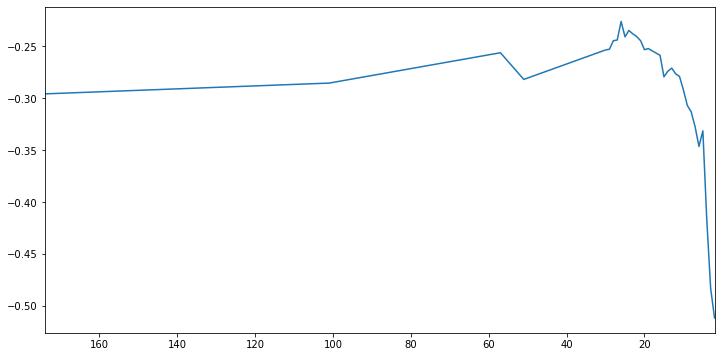

In [11]:
cv_splitter = StratifiedKFold(N_FOLDS, random_state=69, shuffle=True)
w_array = utilities.class_weights(y_train)

xgb_pipe_bounds = {
    'model__max_depth': [2, 8],
    'model__n_estimators': [15, 30],
    'model__learning_rate': [.1, .3],
    'model__reg_lambda': [0, 10],
    'model__colsample_bytree': [.3, 1],
    'model__colsample_bylevel': [.3, 1],
    'model__colsample_bynode': [.3, 1],
}



pipe_tuner = pipeline_tuner.PipelineTuner(
    create_xgb_pipe,
    xgb_pipe_bounds,
    X_train,
    y_train,
    # "roc_auc_ovr_weighted" #"balanced_accuracy" "f1_micro"
    scorer="neg_log_loss", #"neg_log_loss" if len(category_encoder.classes_) > 2 else "roc_auc", 
    cv=cv_splitter,
    weight_array=w_array,
    #patience=2,
)

pipe_tuner.bayes_config(
    n_iter = 200,
    init_points = 50,
    discrete_vars = [f"model__{elem}" for elem in  ["max_depth", "n_estimators"]]
)

pipe_tuner.save( constants.RESULTS_DIRECTORY, results_base)

#pipe_tuner.continue_tuning(
#    os.path.join(constants.RESULTS_DIRECTORY, 'xgb_20210322_0913', 'model.pkl')
#)

pipe_tuner.tune()
pipe_tuner.plot_tuning()

xgb_best_pipe = pipe_tuner.best_pipe
best_features = pipe_tuner.best_features
fs_pipes = pipe_tuner.fs_pipes
fs_scores = pipe_tuner.fs_scores
fs_features = pipe_tuner.fs_features

1: 45
2: 45



cv f1-macro 51.68%
cv f1-micro 56.28%
cv accuracy score for best tree: 56.28%
cv balanced accuracy for best tree: 51.43%
cv confusion


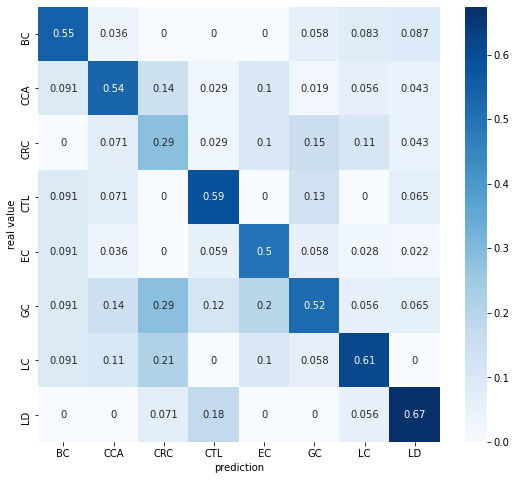

              precision    recall  f1-score   support

          BC       0.55      0.35      0.43        17
         CCA       0.54      0.60      0.57        25
         CRC       0.29      0.18      0.22        22
         CTL       0.59      0.61      0.60        33
          EC       0.50      0.36      0.42        14
          GC       0.52      0.57      0.55        47
          LC       0.61      0.67      0.64        33
          LD       0.67      0.78      0.72        40

    accuracy                           0.56       231
   macro avg       0.53      0.51      0.52       231
weighted avg       0.55      0.56      0.55       231

recall by category


,category,recall
2,CRC,0.181818
0,BC,0.352941
4,EC,0.357143
5,GC,0.574468
1,CCA,0.600000
3,CTL,0.606061
6,LC,0.666667
7,LD (COPD),0.764706
8,LD (PM),0.782609




decision tree feature importance


,name,importance
0,DNAJA1 * DNAJA2 * DNAJC11 * DNAJB1 * DNAJC5 * DNAJC13,4.21%
1,(CCT1 + CCT2 + CCT6A) / HSP90AA1,3.73%
2,(CCT1 + CCT2 + CCT6A) / HSP90AB1,3.27%
3,CCT2 / HSP90AB1,3.26%
4,PPP5C / HSP90AA1,3.17%
5,HSPA6 / TRAP1,3.15%
6,HSPB1 * HSPA6,2.80%
7,FKBP4 / HSP90AA1,2.78%
8,HSP90AA1 / TRAP1,2.78%
9,HSP90AB1 / HSP90B1,2.70%


importance of each individual feature (ordered)


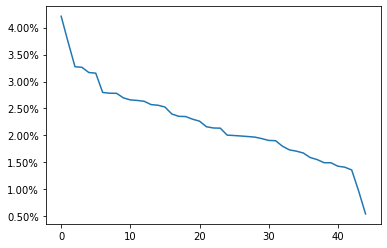

cumulative importance of each feature (ordered)


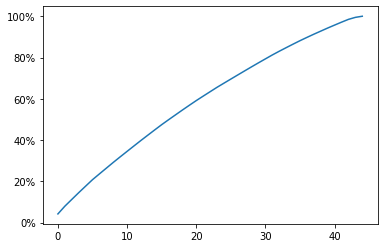

<AxesSubplot:>

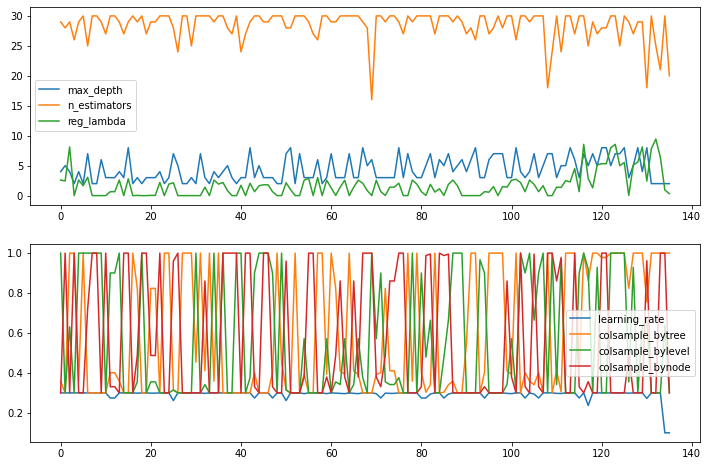

In [31]:
xgb_feat_imp = reporters.report_maker(
    xgb_best_pipe,
    X_train[best_features],
    y_train,
    X_test=None,
    y_test=None,
    category_names=category_encoder.classes_.tolist(),
    categories=data.category.to_list(),
    feature_codes=best_features.tolist(),
    equation_mapping=data_prep.clean_equation_mapping,
    weight_array=w_array,
    cv=cv_splitter
)


all_params = pd.DataFrame([elem["model"].get_params() for elem in fs_pipes])
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
all_params[['max_depth', 'n_estimators', 'reg_lambda']].plot.line(ax=ax[0])
all_params[['learning_rate', 'colsample_bytree', 'colsample_bylevel', 'colsample_bynode']].plot.line(ax=ax[1])

In [ ]:
import importlib
importlib.reload(reporters)

In [ ]:
feature_names = pd.Series(fs_features[fs_scores.idxmax()])
heatmap_data = pd.concat([X_train, category_encoder.inverse_transform(y_train)], 1)
reporters.plot_protein_heatmap(
    heatmap_data,
    feature_names,
    feature_mapping=data_prep.clean_equation_mapping,
    group_proteins=False)

# Shap

In [ ]:
from typing import Dict
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_predict

@typechecked
def categories_shap(
        explainer: shap.Explainer,
        X: pd.DataFrame,
        category_names: List[str],
        feature_names: Dict[str, str]
    ) -> None:
    shap_values = explainer.shap_values(observations)

    for category, shap_category in zip(category_names, shap_values):
        print(category.center(60))
        shap.summary_plot(
            shap_category,
            observations.rename(columns=feature_names),
            title=category,
            alpha=.5
        )


def patient_score(
        model_pipe,
        X,
        y,
        cv,
        category_names
    ):
    pred_probas = cross_val_predict(model_pipe, X, y, cv=cv, n_jobs=-1, method="predict_proba")
    stats = pd.DataFrame(pred_probas, columns=category_names, index=X.index)
    stats["pred"] = stats.idxmax(axis="columns")
    stats["target"] = np.array(category_names)[y]
    stats["good_pred"] = stats["pred"] == stats["target"]
    stats["log_loss"] = [log_loss(real, pred) for real, pred in
        zip(pd.get_dummies(y).values, stats[category_names].values)]
    stats["pred_code"] = pred_probas.argmax(1)
    stats["target_code"] = y
    stats.sort_values("log_loss", inplace=True)
    return stats


def patient_shap(
    explainer,
    pred_probas,
    data_pipe,
    X,
    column_names,
    n_best=1,
    n_worst=1):
  """
  Creates SHAP force plots for each patient.
  """
  def _shap_plot(val):
    return shap.force_plot( 
      explainer.expected_value[row[val]],
      shap_values[row[val]].values.loc[[patient_idx]].values,
      features=X_trans.rename(columns=column_names).loc[[patient_idx]],
      #text_rotation=45
    )

  shap.initjs()
  X_trans = data_pipe.fit_transform(X)
  shap_values = explainer.shap_values(X_trans)
  shap_values = [pd.DataFrame(sv, index=X_trans.index) for sv in shap_values]

  for _, df in predict_probas.groupby("target"):
    print("=" * 30 + f"  {df['target'].iloc[0]}  " + "=" * 30 + "\n")
    mask = [False] * (len(df) - n_best - n_worst)
    mask = [True] * n_best + mask + [True] * n_worst
    display(df[mask])
    for patient_idx, row in df[mask].iterrows():
      if row["good_pred"]:
        correct_wrong = "correctly"
      else:
        correct_wrong = "wrongly"
      print("-" * 50)
      print(f'Patient {patient_idx + 1} with log-loss: {row["log_loss"]:.3}')
      print(f'the true condition {row["target"]} was {correct_wrong} predicted ' +
            f'with probability: {row[row["target"]]:.2}')   
      display(_shap_plot("target_code"))

      if not row["good_pred"]:
        print(f'the wrong condition {row["pred"]} was predicted with ' +
            f'probability: {row[row["pred"]]:.2}')
        display(_shap_plot("pred_code"))

In [ ]:
tree_explainer = shap.TreeExplainer(xgb_best_pipe["model"])
categories_shap(tree_explainer,
                X_train,
                create_preprocess_pipe(columns=feature_names),
                category_encoder.classes_.tolist(),
                equation_mapping)